## Answers Accuracy and Relevance

The goal is to measure the accuracy and relevance of answers for different queries or questions related to the codebase.  
GPT is called to generate answers, which are then evaluated using various methods.

In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parents[0]))

import json
import openai 
import time 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from app.services.chat import ChatService
from app.services.embedder import Embedder
from app.services.qdrant_wrapper import QdrantWrapper
from app.models import AppConfig

import warnings
warnings.filterwarnings("ignore")

config = AppConfig()

/Users/przemyslawniedziela/Desktop/clean air/cleanair/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


### Model run

In this section, we run GPT for the whole question base with a possibly large `K` in order to answer all quantitative questions.  
Note that a `sleep` is added to brute-force bypass the limitation of tokens per minute.


<b>Before running:</b><br>
Make sure Qdrant is running and has at least one collection, e.g. "documents".
You can verify it by running: 
```console
curl <QDRANT_URL>/collections
```

Make sure that OPENAI_API_KEY has a valid key: (openai.api_key)

In [3]:
#openai.api_key = <YOUR API KEY> 

In [4]:
with open("questions.json") as f:
    questions = json.load(f)

In [ ]:
TOP_K = 450

qwrap = QdrantWrapper(collection_name=config.default_collection)
embedder = Embedder(model_name=config.embed_model)

chat_service = ChatService(qwrap, embedder)
answers = [] 
for question in questions: 
    result = chat_service.answer_question(question['question'], top_k=TOP_K)
    context = [
        {
            "id": doc["id"],
            "name": doc["payload"]['TITLE OF THE PAPER'],
            "score": doc["score"]
        }
        for doc in result["context_docs"]
    ]

    answers.append({
        'topic': question['topic'],
        'author': question['author'],
        'question': question['question'], 
        'answer': result["answer"],
        'context_docs': context
    })
    time.sleep(20)

In [6]:
answers_df = pd.DataFrame(answers)
answers_df.to_csv("answers.csv")

### Evaluating Semantic Similarity Scores 

In [7]:
data = []
for ans in answers:
    for doc in ans['context_docs']:
        data.append({ 
            'topic_author': f"{ans['topic']} \n author: {ans['author']}",
            'score': doc['score']
        })

topic_df = pd.DataFrame(data)

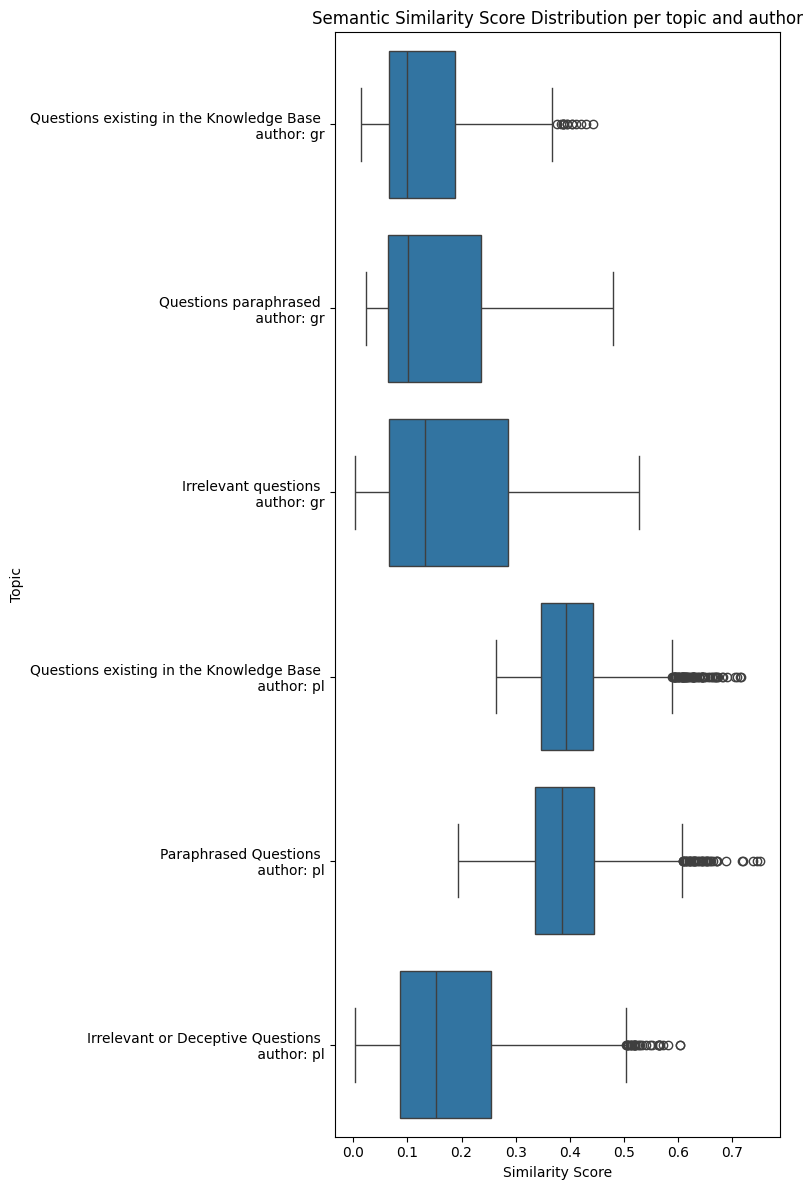

In [8]:
plt.figure(figsize=(8, 12))  
sns.boxplot(y='topic_author', x='score', data=topic_df)  
plt.yticks(rotation=0, ha='right')  
plt.title('Semantic Similarity Score Distribution per topic and author')
plt.xlabel('Similarity Score')
plt.ylabel('Topic')
plt.tight_layout()
plt.show()


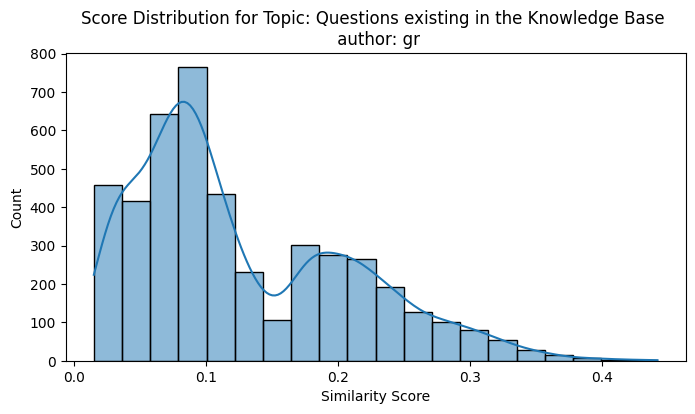

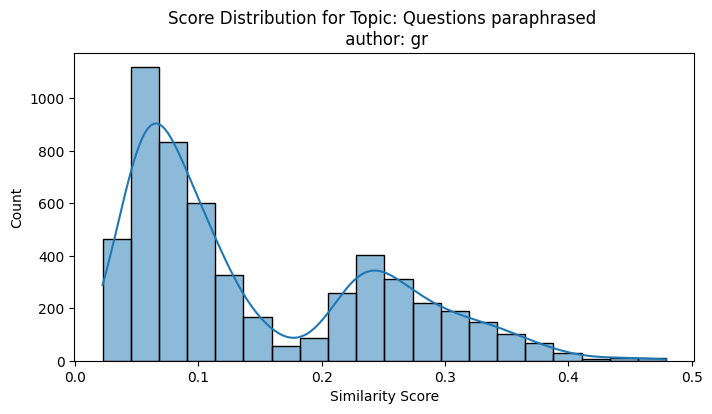

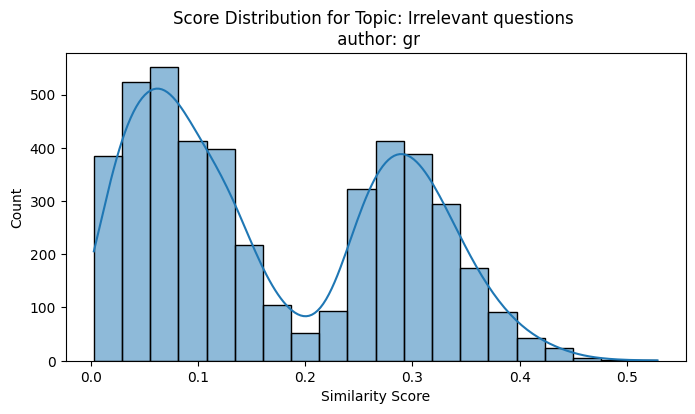

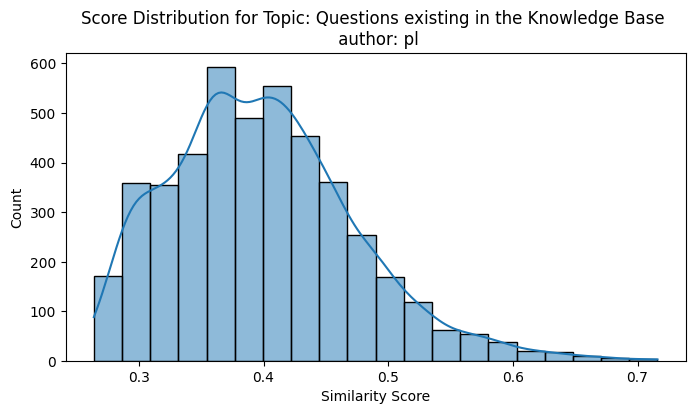

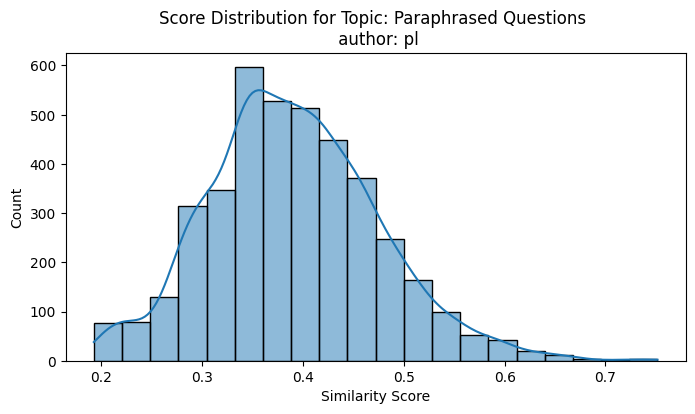

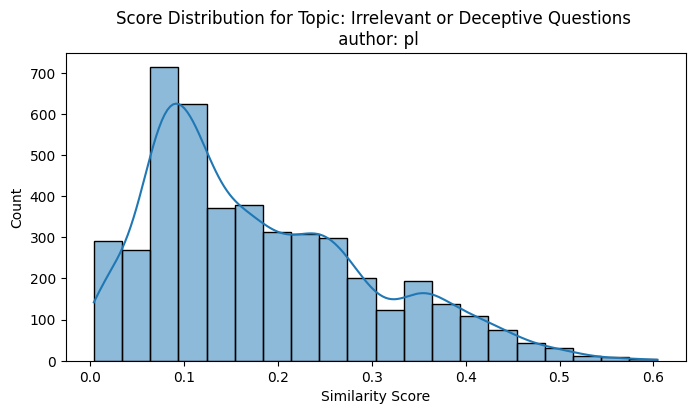

In [9]:
topics = topic_df['topic_author'].unique()
for topic in topics:
    plt.figure(figsize=(8, 4))
    sns.histplot(topic_df[topic_df['topic_author'] == topic]['score'], bins=20, kde=True)
    plt.title(f'Score Distribution for Topic: {topic}')
    plt.xlabel('Similarity Score')
    plt.ylabel('Count')
    plt.show()
